In [18]:
#%run utility_GetInputHits.py
%qtconsole --style monokai

In [19]:
from HGCalImageAlgo3D import *
from timeit import default_timer as timer

%matplotlib inline
plt.style.use('classic')
plt.rc("figure",facecolor="w",figsize=(6,4))
plt.rc("font",size=10)
plt.rc("savefig",dpi=300)

In [20]:
DatasetFile   = 'CMSSW9304_partGun_PDGid22_x1000_E300.0To300.0_NTUP'
df  = pd.read_pickle("../data/input/"+DatasetFile+"_rechit.pkl") 

# 1. Run clustering

In [21]:

dfresultclus     = pd.DataFrame()

time0 = timer()
for ievt in tqdm.tqdm(np.unique(df.id)):
    if ievt<1000:
        #_,dfevtclus   = ImageAlgorithm_cpu (df[df.id==ievt],ievt)
        #_,dfevtclus   = ImageAlgorithm_cuda(df[df.id==ievt],ievt)
        _,dfevtclus   = ImageAlgorithm_opencl(df[df.id==ievt],ievt,1)
        dfresultclus  = dfresultclus.append(dfevtclus, ignore_index=True)
time1 = timer()
print(time1-time0)

dfresultclus.to_pickle("../data/output/"+DatasetFile+"_OutputClus.pkl")

100%|██████████| 1000/1000 [00:35<00:00, 32.42it/s]

35.16083547100061


In [6]:
# if want multiprocessing different files on different devices
p1 = mp.Process(target=ImageAlgorithm_opencl_job,
                args=("../data/input/"+DatasetFile+"_rechit.pkl",1))
time0 = timer()
p1.start()
p1.join()
time1 = timer()
print(time1-time0)

# 2.Make Some Plots

In [4]:
dfc = read_root("/Users/zihengchen/Documents/HGCal/clustering/data/"+DatasetFile+".root",'ana/hgc')
energy3d,count3d = [],[]
for i in np.arange(len(dfc)):
    slt = dfc.multiclus_z[i]>0
    energyi = dfc.multiclus_energy[i][slt]
    energy3d.append(np.sum(energyi))
    count3d.append(energyi.size)
energy3d = np.array(energy3d)
count3d = np.array(count3d)

In [5]:
def effsigma(arr):
    ntotal = len(arr)
    npeak  = int(0.683*ntotal)
    ewidth = int(1e5)

    e = sort(arr)[::-1]
    for i in range(ntotal-npeak-1):
        temp = e[i]-e[i+npeak]
        if temp<ewidth:
            ewidth = temp 
    return ewidth/2,e.mean()

ImageAlgo3D:0.017604371052390586,293.8875833257041
cmssw:0.018097635904947916,285.36041259765625


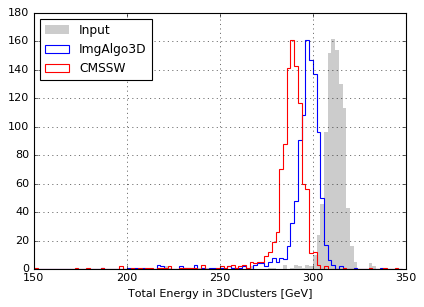

In [12]:
f = plt.hist(dfresultclus["clust_inputenergy"],color="k",bins=np.arange(150,350,2),alpha=0.2,histtype="stepfilled",lw=0,label="Input")
f = plt.hist(dfresultclus["clust_includedenergy"],color="b",bins=np.arange(150,350,2),alpha=1,histtype="step",lw=1,label="ImgAlgo3D")
f = plt.hist(energy3d,color="r",bins=np.arange(150,350,2),alpha=1,histtype="step",lw=1,label="CMSSW")

plt.grid(True)
plt.legend(loc="upper left",fontsize=11)
plt.xlabel("Total Energy in 3DClusters [GeV]")


eff,ave = effsigma(dfresultclus["clust_includedenergy"])
eff = eff/300

print("ImageAlgo3D:{},{}".format(eff,ave))

eff,ave = effsigma(energy3d)
eff = eff/300
print("cmssw:{},{}".format(eff,ave))

plt.savefig("../plot/result_energy.png")

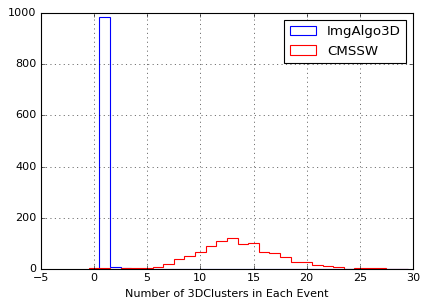

In [13]:
f = plt.hist(dfresultclus["clust_n"],bins=np.arange(-.5,30,1),color="b",alpha=1,
             histtype="step", lw=1,label="ImgAlgo3D")
f = plt.hist(count3d,bins=np.arange(-.5,30,1),color="r",alpha=1,
             histtype="step", lw=1,label="CMSSW")
plt.grid(True)
plt.legend()
plt.xlabel("Number of 3DClusters in Each Event")
plt.savefig("../plot/result_nclus.png")

In [9]:
import multiprocessing as mp

def job(a,d):
    print('aaaaa')
def job2(a,d):
    print('bbbbb')
    
p1 = mp.Process(target=job,args=(1,2))
p2 = mp.Process(target=job2,args=(1,2))
p1.start()
p2.start()
p1.join()
p2.join()

aaaaa
bbbbb
